Input dataset:
- training_data_mv.csv

This notebook includes:
- Accuracy analysis of random forest classifier
- Feature importance of random forest classifier
- Classifier of sequence-based features

# Import libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scikitplot as skplt
import seaborn as sns
import sklearn.metrics as metrics

from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.svm import LinearSVC, SVC

%matplotlib inline

# Define paths

In [4]:
# user = 'kathi'
user = 'DeaGogishvili'

Data_path = '/Users/' + user + '/Documents/GitHub/ExtracellularVesicles/Data'

# Import dataset

### Feature dataset (Microvesicle)

In [5]:
df = Data_path + '/MachineLearning/training_data_mv.csv' 
df_mv = pd.read_csv(df, sep=',', engine='python')

In [6]:
df_mv

,id,length,hydr_count,polar_count,molecular_weight,helix,turn,sheet,A,C,...,ww_domain,RAS_profile,EGF,RRM,coiled_coil,transmembrane,TMHMM,Polar_exposed,Hydrophobic_exposed,Microvesicle
0,Q92667,9.818582,0.376523,0.370986,16.793404,0.079734,0.805094,0.115172,0.079734,0.018826,...,0,0,0,0,1,1,1,0.447738,0.263651,0
1,P62736,8.558421,0.427056,0.379310,15.574035,0.445623,0.347480,0.206897,0.076923,0.018568,...,0,0,0,0,0,0,0,0.682540,0.111111,1
2,P0C7M7,9.179909,0.424138,0.379310,16.216178,0.320690,0.448276,0.231034,0.058621,0.022414,...,0,0,0,0,0,0,0,0.661111,0.088889,0
3,P49703,7.651052,0.417910,0.402985,14.652697,0.328358,0.477612,0.194030,0.099502,0.004975,...,0,0,0,0,0,0,0,0.567010,0.195876,0
4,Q5TGY3,10.646559,0.331878,0.318777,17.589293,0.097941,0.853400,0.048659,0.104803,0.018715,...,0,0,0,0,1,0,0,0.411705,0.188698,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15040,Q96H40,8.854868,0.330454,0.498920,15.918914,0.399568,0.494600,0.105832,0.032397,0.056156,...,0,0,0,0,0,0,0,0.659664,0.105042,0
15041,Q9BTX3,7.434628,0.514451,0.306358,14.472938,0.624277,0.352601,0.023121,0.104046,0.011561,...,0,0,0,0,0,1,1,0.460674,0.382022,0
15042,A6NFC5,7.800900,0.560538,0.179372,14.739747,0.573991,0.300448,0.125561,0.121076,0.031390,...,0,0,0,0,0,1,1,0.310000,0.420000,0
15043,Q8WV44,9.299208,0.365079,0.453968,16.340760,0.296825,0.528571,0.174603,0.077778,0.030159,...,0,0,0,0,0,0,0,0.658824,0.132353,0


# Create training and test sets

In [7]:
# define explanatory and response variables
X = df_mv.drop(["Microvesicle"], axis=1)
y = df_mv[["Microvesicle"]]

# split 80% training and 20% test 
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

# convert dataframe column to array
train_y = train_y['Microvesicle'].values
test_y = test_y['Microvesicle'].values

In [8]:
print("Number of proteins in training set:", len(train_X))
print("Number of proteins in testing set:", len(test_X))

Number of proteins in training set: 12036
Number of proteins in testing set: 3009


### Balance datasets

In [9]:
print("Number of non EV proteins in training set:", len(train_y[train_y == 0]))
print("Number of EV proteins in training set:", len(train_y[train_y == 1]))

# undersample majority class
undersample = RandomUnderSampler()
train_X_balanced, train_y_balanced = undersample.fit_resample(train_X, train_y)

print("---------------")
print("Number of non EV proteins in training set after sampling:", len(train_y_balanced[train_y_balanced == 0]))
print("Number of EV proteins in training set after sampling:", len(train_y_balanced[train_y_balanced == 1]))

Number of non EV proteins in training set: 9647
Number of EV proteins in training set: 2389
---------------
Number of non EV proteins in training set after sampling: 2389
Number of EV proteins in training set after sampling: 2389


# Feature scaling

In [10]:
features_continuous = ['length', 'hydr_count', 'polar_count', 'molecular_weight', 'helix', 'turn', 'sheet', 'A', 'C', 'D', 
                       'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2',
                       'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder', 'A_exposed', 'C_exposed', 'D_exposed', 'E_exposed', 
                       'F_exposed', 'G_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed', 'N_exposed', 
                       'P_exposed', 'Q_exposed', 'R_exposed', 'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed',
                       'Prob. of Solubility', 'Aggregation_propensity', 'Aromaticity', 'Instability_index', 'Gravy', 
                       'isoelectric_point', 'charge_at_7', 'charge_at_5', 'Polar_exposed', 'Hydrophobic_exposed']

In [11]:
# robust scaling
train_X_rob = train_X_balanced.copy()
test_X_rob = test_X.copy()
train_X_rob[features_continuous] = RobustScaler().fit_transform(train_X_balanced[features_continuous])
test_X_rob[features_continuous] = RobustScaler().fit_transform(test_X[features_continuous])

In [12]:
train_X_rob = train_X_rob.drop(columns=['id'])
test_X_rob = test_X_rob.drop(columns=['id'])

# Analysis of random forest classifier

### Build random forest classification model

In [11]:
rf = RandomForestClassifier(random_state=0, n_estimators=10000, max_features=10)
rf.fit(train_X_rob, train_y_balanced)
y_pred = rf.predict(test_X_rob)

In [12]:
# filepath = "/Users/kathi/Documents/GitHub/EV/Models/"  

# # save the model 
# with open(filepath + 'RF_model_mv.pkl', 'wb') as f:  
#     pickle.dump(rf, f)
    
# # save the associated test data
# test_X_rob.to_csv('/Users/kathi/Documents/GitHub/EV/Models/test_X_rob_mv.csv', index=False)
# with open(filepath + 'test_y_mv.pkl', 'wb') as f:  
#     np.save(f, test_y)

### ROC curve

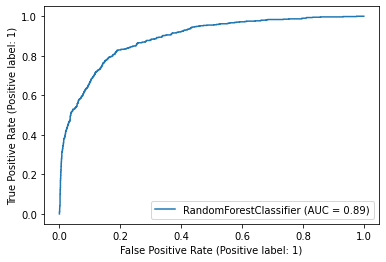

In [13]:
metrics.plot_roc_curve(rf, test_X_rob, test_y);

### Confusion matrix

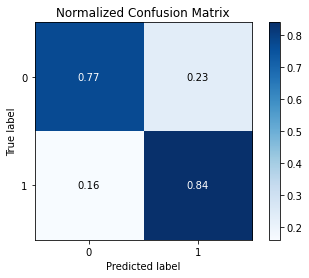

In [14]:
skplt.metrics.plot_confusion_matrix(test_y, y_pred, normalize=True);

### Feature importance

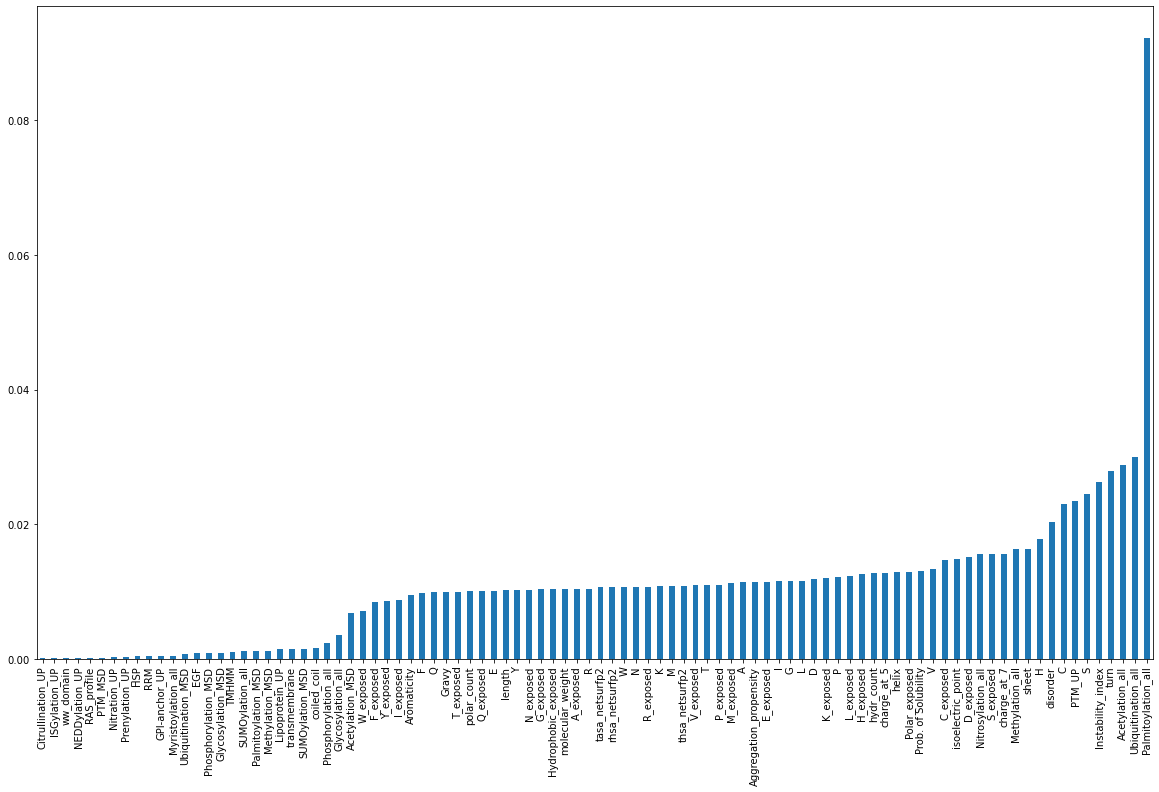

In [15]:
feature_importance = pd.Series(index = train_X_rob.columns, data = rf.feature_importances_)
feature_importance.sort_values().plot(kind='bar', figsize=(20,12))
feature_importance.to_csv(Data_path + '/Feature_importance/Feature_importance_RF_mv.csv', index=True)

fig = plt.gcf()
#fig.savefig(Figure_path + '/Microvesicle/Feature_importance_RF_Microvesicle.png', dpi = 150)

# Sequence-based classifier

In [16]:
# use only sequence-based features
seq_features = ['length', 'hydr_count', 'polar_count', 'molecular_weight', 'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E', 'F', 
                'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2', 'tasa_netsurfp2', 
                'rhsa_netsurfp2', 'disorder', 'A_exposed', 'C_exposed', 'D_exposed', 'E_exposed', 'F_exposed',
                'G_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed', 'N_exposed', 'P_exposed', 
                'Q_exposed', 'R_exposed', 'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed', 
                'Prob. of Solubility', 'Aggregation_propensity', 'Aromaticity', 'Instability_index', 'Gravy', 
                'isoelectric_point', 'charge_at_7', 'charge_at_5', 'PTM_MSD', 'Phosphorylation_MSD',
                'Glycosylation_MSD', 'Ubiquitination_MSD', 'SUMOylation_MSD', 'Acetylation_MSD', 'Palmitoylation_MSD', 
                'Methylation_MSD', 'coiled_coil', 'RAS_profile', 'ww_domain', 'EGF', 'RRM',
                'TMHMM', 'Polar_exposed', 'Hydrophobic_exposed']

train_X_seq = train_X_rob[seq_features]
test_X_seq = test_X_rob[seq_features]

print(train_X_seq.shape)
print(train_y_balanced.shape)
print(test_X_seq.shape)
print(test_y.shape)

(4778, 75)
(4778,)
(3009, 75)
(3009,)


In [17]:
rf_seq = RandomForestClassifier(random_state=0, n_estimators=10000, max_features=10)
rf_seq.fit(train_X_seq, train_y_balanced)
y_pred_seq = rf_seq.predict(test_X_seq)

In [18]:
# filepath = "/Users/kathi/Documents/GitHub/EV/Models/"  

# # save the model 
# with open(filepath + 'RF_model_mv_seq.pkl', 'wb') as f:  
#     pickle.dump(rf_seq, f)
    
# # save the associated test data
# test_X_seq.to_csv('/Users/kathi/Documents/GitHub/EV/Models/test_X_mv_seq.csv', index=False)
# with open(filepath + 'test_y_mv_seq.pkl', 'wb') as f:  
#     np.save(f, test_y)

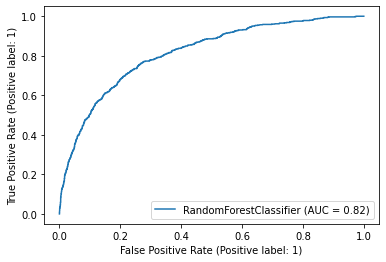

In [19]:
metrics.plot_roc_curve(rf_seq, test_X_seq, test_y);

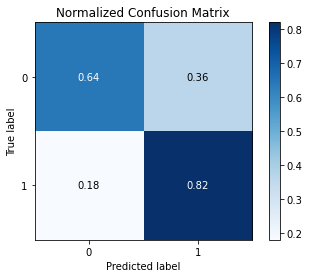

In [20]:
skplt.metrics.plot_confusion_matrix(test_y, y_pred_seq, normalize=True);

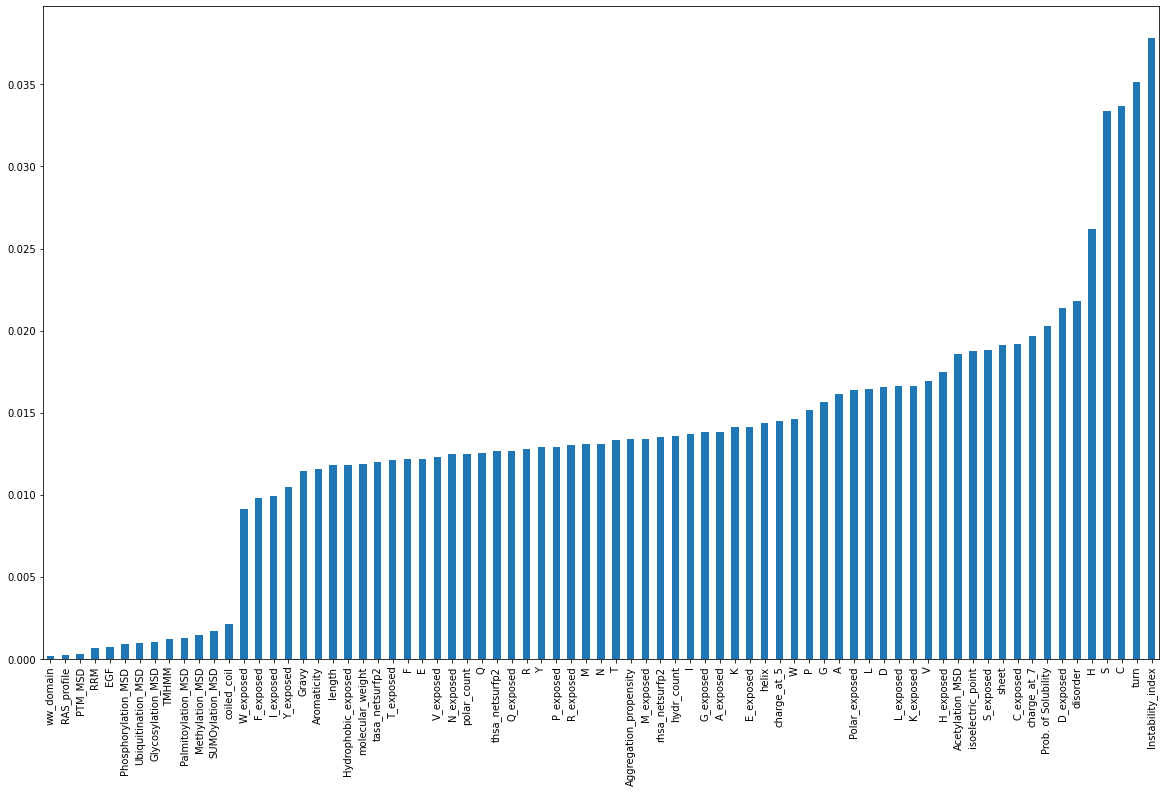

In [21]:
feature_importance = pd.Series(index = train_X_seq.columns, data = rf_seq.feature_importances_)
feature_importance.sort_values().plot(kind='bar', figsize=(20,12))

fig = plt.gcf()
#fig.savefig(Figure_path + '/Microvesicle/Feature_importance_RF_seq_Microvesicle.png', dpi = 150)

# Transmembrane association

In [31]:
df_tm = df_mv[df_mv["transmembrane"] == 1]
df_non_tm = df_mv[df_mv["transmembrane"] == 0]

df_tm = df_tm.drop(columns=['id'])
df_non_tm = df_non_tm.drop(columns=['id'])

print(df_tm.shape)
print(df_non_tm.shape)

(4429, 95)
(10616, 95)


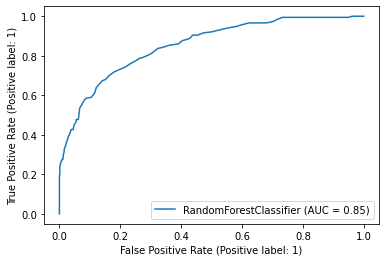

In [32]:
# define explanatory and response variables
X = df_tm.drop(["Microvesicle"], axis=1)
y = df_tm[["Microvesicle"]]

# split 80% training and 20% test 
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

# convert dataframe column to array
train_y = train_y['Microvesicle'].values
test_y = test_y['Microvesicle'].values

# undersample majority class
undersample = RandomUnderSampler()
train_X_balanced, train_y_balanced = undersample.fit_resample(train_X, train_y)

rf = RandomForestClassifier(random_state=0).fit(train_X_balanced, train_y_balanced)
y_pred = rf.predict(test_X)

metrics.plot_roc_curve(rf, test_X, test_y);

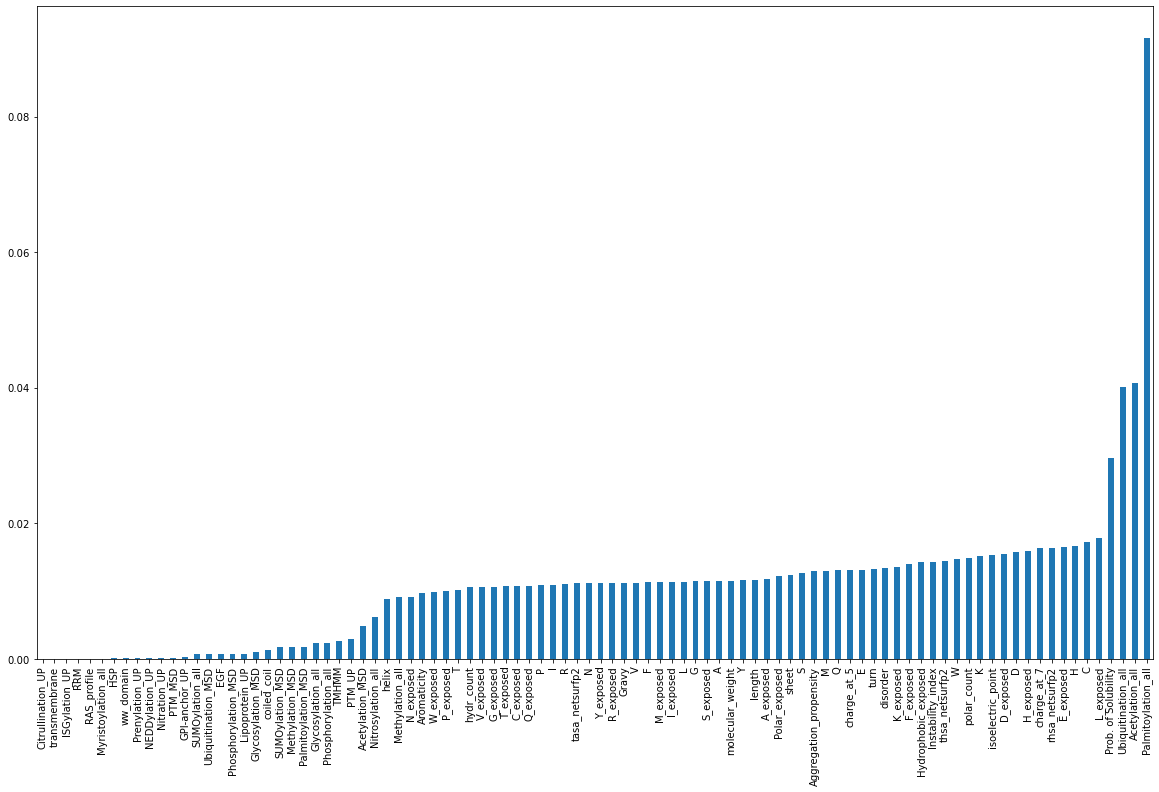

In [33]:
feature_importance = pd.Series(index = train_X.columns, data = rf.feature_importances_)
feature_importance.sort_values().plot(kind='bar', figsize=(20,12));

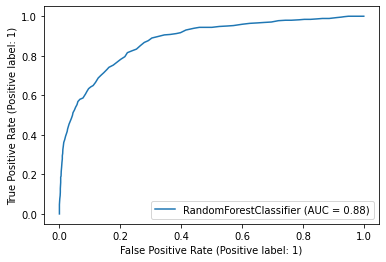

In [34]:
# define explanatory and response variables
X = df_non_tm.drop(["Microvesicle"], axis=1)
y = df_non_tm[["Microvesicle"]]

# split 80% training and 20% test 
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

# convert dataframe column to array
train_y = train_y['Microvesicle'].values
test_y = test_y['Microvesicle'].values

# undersample majority class
undersample = RandomUnderSampler()
train_X_balanced, train_y_balanced = undersample.fit_resample(train_X, train_y)

rf = RandomForestClassifier(random_state=0).fit(train_X_balanced, train_y_balanced)
y_pred = rf.predict(test_X)

metrics.plot_roc_curve(rf, test_X, test_y);

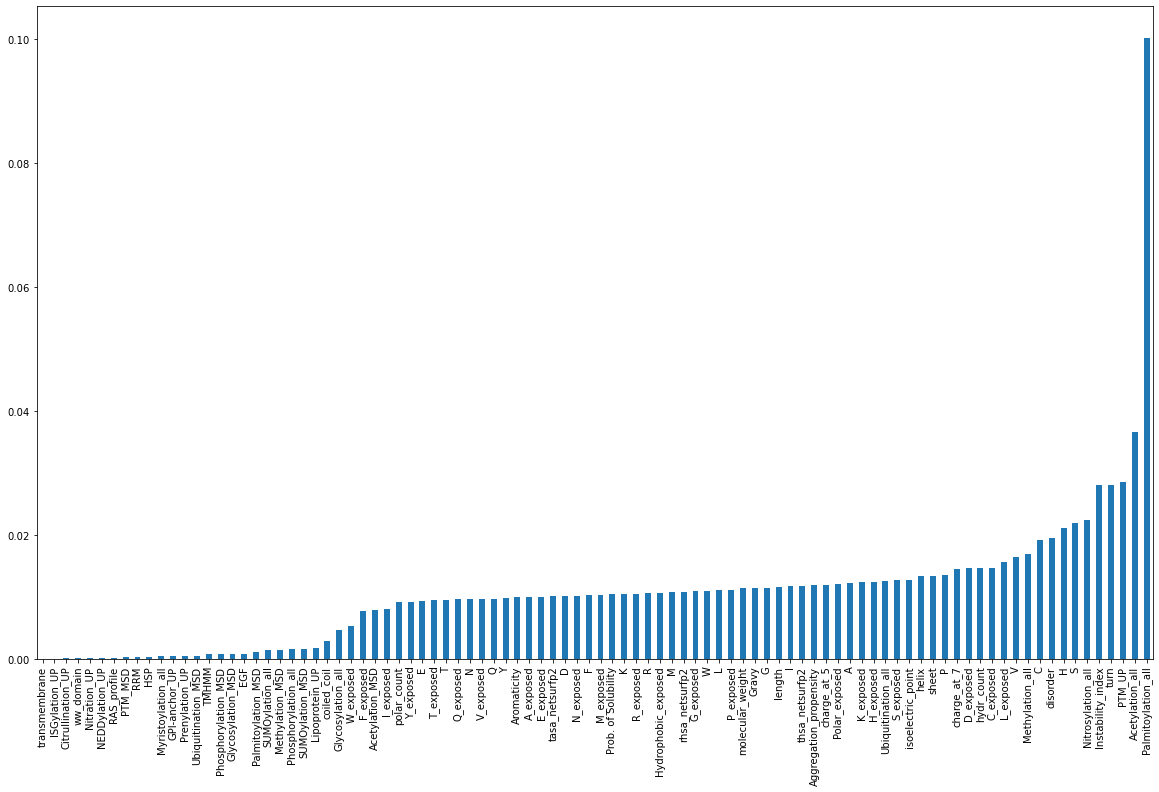

In [35]:
feature_importance = pd.Series(index = train_X_balanced.columns, data = rf.feature_importances_)
feature_importance.sort_values().plot(kind='bar', figsize=(20,12));